In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [67]:
import nflib
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm, AffineConstantFlow, LinearFlow
import nflib.coupling_flows as icf
import nflib.inn_flow as inn
import nflib.res_flow as irf

In [3]:
from torch import distributions
from torch.distributions import MultivariateNormal

In [4]:
device = torch.device("cuda:1")
# device = torch.device("cpu")

## MNIST dataset

In [5]:
import mylibrary.datasets as datasets
import mylibrary.nnlib as tnn

In [6]:
mnist = datasets.FashionMNIST()
# mnist.download_mnist()
# mnist.save_mnist()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

# train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [7]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)
test_label = torch.LongTensor(test_label_)

In [8]:
input_size = 784
output_size = 10

In [9]:
class MNIST_Dataset(data.Dataset):
    
    def __init__(self, data, label):
        self.data = data
        self.label = label
        
#         self.label = mask.type(torch.float32).reshape(-1,1)
#         self._shuffle_data_()
        
    def __len__(self):
        return len(self.data)
    
#     def _shuffle_data_(self):
#         randidx = random.sample(range(len(self.data)), k=len(self.data))
# #         self.data = self.data[randidx]
# #         self.label = self.label[randidx]
    
    def __getitem__(self, idx):
        img, lbl = self.data[idx], self.label[idx]
        return img, lbl

In [10]:
class Subset_Dataset(data.Dataset):
    
    def __init__(self, dataset, index):
        self.dataset = dataset
        self.index = index
        
    def __len__(self):
        return len(self.index)
    
    def __getitem__(self, idx):
        idx = self.index[idx]
        img, lbl = self.dataset[idx]
        return img, lbl

In [11]:
## The classifiers store all the data in INDEX FORM

In [12]:
train_dataset = MNIST_Dataset(train_data, train_label)
test_dataset = MNIST_Dataset(test_data, test_label)

In [13]:
train_dataset[[0,1,2]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([9, 0, 0]))

In [14]:
class ConnectedClassifier_SoftKMeans(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
        self.centers = nn.Parameter(torch.rand(num_sets, input_dim)*2-1)
        
#         self.cls_weight = nn.Parameter(torch.ones(num_sets, output_dim)/output_dim)
        init_val = torch.randn(num_sets, output_dim)*0.01
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 2.
#             init_val[ns, 0] = 2. ### initialize same class in all clusters

        self.cls_weight = nn.Parameter(init_val)

        self.cls_confidence = None
        
        
    def forward(self, x, hard=False):
        self.cls_weight.data = torch.abs(self.cls_weight.data)/self.cls_weight.data.sum(dim=1, keepdim=True)
        
        x = x[:, :self.input_dim]
        dists = torch.cdist(x, self.centers)
        dists = dists/np.sqrt(self.input_dim) ### correction to make diagonal of unit square 1 in nD space
        
        if hard:
            x = torch.softmax(-dists*1e5, dim=1)
        else:
            x = torch.softmax(-dists*self.inv_temp, dim=1)
        self.cls_confidence = x
#         c = torch.softmax(self.cls_weight, dim=1)
        c = self.cls_weight
        return x@c ## since both are normalized, it is also normalized

In [15]:
class ClassifierTree:
    
    def __init__(self, train_data, test_data, device):
        self.root = LocalClassifier(device)
        self.root.create_network_0(784, [784], 10, 10)
        
        self.train_data = train_data
        self.test_data = test_data
        self.device = device
        pass
    
    def display_stats(self):
        indexing = "0"
        self.root.display_stats(indexing)
        acc, tot = self.root.get_correct_train()
        train_acc = acc/tot
        acc, tot = self.root.get_correct_test()
        test_acc = acc/tot
        print(f"Final Accuracy is Train: {train_acc :.5f} Test: {test_acc :.5f}")
            
    def get_parent_node(self, index_list:list):
        parent = self.root
        index_list = index_list[1:]
        for idx in index_list[:-1]:
            parent = parent.children[idx]
        return parent
    
    def get_node(self, index_list:list):
        parent = self.root
        index_list = index_list[1:]
        for idx in index_list[:-1]:
            parent = parent.children[idx]
        child = parent.children[index_list[-1]]
        return child
    
    
    def get_all_child_index(self):
        child_list = []
        self.root.get_all_index([0], child_list)
        return child_list

In [68]:
class LeafNode:
    def __init__(self):
        self.pred = None
        self.classes = None
        self.num_correct = None
        self.train_indices = None
        self.test_indices = None
        self.test_correct = None
        
    def display_stats(self, indexing):
        print(f"[{indexing}] : Train -> {self.num_correct/len(self.train_indices) :.4f}", end=" ")
        
        if len(self.test_indices)>0:
            test_acc = self.test_correct/len(self.test_indices)
        else:
            test_acc = -1
        print(f"Test -> {test_acc :.4f}, NUM: {len(self.train_indices)}, classes: {self.pred}:{self.classes}")

    def get_correct_train(self):
        return self.num_correct, len(self.train_indices)
    
    def get_correct_test(self):
        return self.test_correct, len(self.test_indices)
    
    def get_all_index(self, indexing, indx_lst):
        indx_lst.append(indexing)
                
        
    

class LocalClassifier:
    
    def __init__(self, device):
        self.model = None
        self.classifier = None
        self.device = device
        
        ### for training purposes
        self.train_loader = None
        self.test_loader = None
        self.optimizer = None
        self.frozen = False
        self.criterion = None
        
        ### after freazing the model, record stats
        self.children = []
    
    def create_network_0(self, input_dim, hidden_dims:list, output_dims, num_classifiers):
        actf = irf.Swish
        flows = []
        flows.append(ActNorm(input_dim))
#         for i in range(len(hidden_dims)):
#             if isinstance(hidden_dims[i], list):
#                 hdi = hidden_dims[i]
#             else:
#                 hdi = [hidden_dims[i]]
#             flows.append(irf.ResidualFlow(input_dim, hdi, activation=actf))
# #             flows.append(ActNorm(input_dim))

        flows.append(LinearFlow(784))
        
        invertible = SequentialFlow(flows)
        self.model = invertible.to(device)
        
        classifier = ConnectedClassifier_SoftKMeans(784, num_classifiers, output_dims)
        self.classifier = classifier.to(device)
        
    def create_train_loader_1(self, train_dataset, index, batch_size):
        dataset = Subset_Dataset(train_dataset, index)
        print(f"Train Dataset Num: {len(index)}")
        self.train_loader = data.DataLoader(dataset=dataset,
                                            num_workers=4, 
                                            batch_size=batch_size, 
                                            shuffle=True)
    
    def create_test_loader_2(self, test_dataset, index, batch_size):
        dataset = Subset_Dataset(test_dataset, index)
        print(f"Test Dataset Num: {len(index)}")
        self.test_loader = data.DataLoader(dataset=dataset,
                                            num_workers=4, 
                                            batch_size=batch_size, 
                                            shuffle=False)
        
    def create_optimizer_3(self, lr):
        self.optimizer = optim.Adam(list(self.model.parameters())+list(self.classifier.parameters()), 
                                    lr=lr, weight_decay=1e-15)
        self.criterion = nn.CrossEntropyLoss()
        
        
    def train_classifier_4(self, epochs, ):
        if self.frozen:
            raise ValueError("This classifier is frozen. Training it might cause errors in childern classifiers")
            
    ############# TRAINING FUNCTIONALITY BELOW ####################    

        index = 0
        train_accs, test_accs = [], []
        for epoch in tqdm(list(range(epochs))):
            train_acc = 0
            train_count = 0
            for xx, yy in self.train_loader:
                xx, yy = xx.to(device), yy.to(device)
#                 print(xx)
                yout = self.model(xx)
#                 print(yout, torch.count_nonzero(torch.isnan(yout)))
                yout = self.classifier(yout)    
#                 print(yout, torch.count_nonzero(torch.isnan(yout)))
                loss = self.criterion(yout, yy)
#                 print(loss)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
#                 losses.append(float(loss))

                outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
                correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
                train_acc += correct
                train_count += len(outputs)

            train_accs.append(float(train_acc)/train_count*100)
            train_acc = 0
            train_count = 0

            print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}')
            test_count = 0
            test_acc = 0
            for xx, yy in self.test_loader:
                xx, yy = xx.to(device), yy.to(device)
                with torch.no_grad():
                    yout = self.classifier(self.model(xx))    
                outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
                correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
                test_acc += correct
                test_count += len(xx)
            test_accs.append(float(test_acc)/test_count*100)
            print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
            print()

        ### after each class index is finished training
        print(f'\t-> MAX Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}')
        
        
    def freeze_and_compute_stats_5(self, MIN_POINTS):
        assert MIN_POINTS > 0
        if self.frozen:
            raise ValueError("This classifier is frozen. The stat has already been calculated")
            
        self.frozen = True
        
        ### delete optimizer, frees memory
        del self.optimizer
        ### take classifier to eval mode
        self.model.eval()
        self.classifier.eval()
        
        with torch.no_grad():
            #### remove classifier with no data or few data.

            set_count = torch.zeros(self.classifier.num_sets).to(device)
            for xx, yy in self.train_loader:
                xx, yy = xx.to(device), yy.to(device)
                with torch.no_grad():
                    yout = self.classifier(self.model(xx), hard=True)

                cls_indx = torch.argmax(self.classifier.cls_confidence, dim=1)
                set_indx, count = torch.unique(cls_indx, return_counts=True) 
                set_count[set_indx] += count

            #### find only the classifier having some data
            classifier_index = []
            classifier_count = []

            for i, cnt in enumerate(set_count.type(torch.long).tolist()):
    #             if cnt == 0: continue
                if cnt < MIN_POINTS: continue

                classifier_index.append(i)
                classifier_count.append(int(cnt))

            #### remove the classifier representing no data
            #### OR representing data less than given N
            print(f"Keeping only N={len(classifier_index)}/{len(self.classifier.centers)} classifiers.")
            self.classifier.centers.data = self.classifier.centers.data[classifier_index]
            self.classifier.cls_weight.data = self.classifier.cls_weight.data[classifier_index]
            ### removed

            ###### compute stats now, from pruned tree.
            def get_Cs_Os_Ts_Zs(data_loader):
                Cs = [] ## winning classifier
                Os = [] ## output of winning classifier
                Ts = [] ## target class
                Zs = []

                for xx, yy in data_loader:
                    Ts.append(yy)
                    xx, yy = xx.to(device), yy.to(device)
                    with torch.no_grad():
                        zz = self.model(xx)
                        Zs.append(zz.data.cpu())
                        yout = self.classifier(zz, hard=True)
                        Os.append(torch.argmax(yout, dim=1).data.cpu())

                    cls_indx = torch.argmax(self.classifier.cls_confidence, dim=1)
                    Cs.append(cls_indx)

                Cs = torch.cat(Cs, dim=0)
                Ts = torch.cat(Ts, dim=0)
                Os = torch.cat(Os, dim=0)
                Zs = torch.cat(Zs, dim=0)
                return Cs, Ts, Os, Zs


            unshuffled_data = data.DataLoader(dataset=self.train_loader.dataset,
                                                num_workers=4, 
                                                batch_size=self.train_loader.batch_size, 
                                                shuffle=False)
            Cs, Ts, Os, Zs = get_Cs_Os_Ts_Zs(unshuffled_data)
            _Cs, _Ts, _, _Zs = get_Cs_Os_Ts_Zs(self.test_loader)

            print("Hard inference on the data !")
            self.children = []
            acc = 0
            for cls_idx in range(len(self.classifier.centers)):
                data_idx = torch.nonzero(Cs == cls_idx)
                Ti = Ts[data_idx]

                ### get prediction according to data
                cls, count = torch.unique(Ti, return_counts=True, sorted=True)
                pred = cls[torch.argmax(count)]
                p = (Ti==pred).type(torch.float32).sum()
                acc += p

                child = LeafNode()
                child.pred = int(pred)
                child.classes = cls.tolist()
                child.num_correct = int(p)
                child.train_indices = data_idx.cpu().reshape(-1)
                
                test_idx = torch.nonzero(_Cs == cls_idx)
                test_p = (_Ts[test_idx]==pred).type(torch.float32).sum()
                child.test_indices = test_idx.cpu().reshape(-1)
                child.test_correct = int(test_p)

                self.children.append(child)

                print(f"idx: {cls_idx}\tout: {int(pred)} \t acc: {p/len(Ti)*100 :.3f} \tclasses:{cls.tolist()}")

            print(f"Accuracy: {float(acc)/len(Ts)}")
        return Zs, Ts, _Zs, _Ts
        
        
    def display_stats(self, indexing):
        for i, c in enumerate(self.children):
            c.display_stats(indexing+f", {i}")
            
    def get_all_index(self, indexing:list, indx_lst):
        for i, c in enumerate(self.children):
            c.get_all_index(indexing+[i], indx_lst)
        pass

    def get_correct_train(self):
        a, b = 0, 0
        for i, c in enumerate(self.children):
            _a, _b = c.get_correct_train()
            a+= _a
            b+= _b
        return a, b
    
    def get_correct_test(self):
        a, b = 0, 0
        for i, c in enumerate(self.children):
            _a, _b = c.get_correct_test()
            a+= _a
            b+= _b
        return a, b
        
    def inference_forward(self, x):
        with torch.no_grad():
            zz = self.model(x)
            yout = self.classifier(zz, hard=True)
            return torch.argmax(classifier.cls_confidence, dim=1)

In [69]:
tree = ClassifierTree(train_dataset, test_dataset, device)

In [70]:
tree.root.create_network_0(784, [784], 10, 10)

In [71]:
tree.root.create_train_loader_1(train_dataset, 
                                torch.arange(0, len(train_dataset), dtype=torch.long), 
                                50)

Train Dataset Num: 60000


In [72]:
tree.root.create_test_loader_2(test_dataset, 
                               torch.arange(0, len(test_dataset), dtype=torch.long), 
                               50)

Test Dataset Num: 10000


In [73]:
tree.root.create_optimizer_3(lr=0.0003)

In [74]:
# list(tree.root.classifier.parameters())

In [75]:
# tree.root.model(torch.randn(10, 784).to(device))

In [76]:
tree.root.train_classifier_4(50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0:0,  Loss:2.1633331775665283


  2%|▏         | 1/50 [00:04<03:20,  4.09s/it]

Train Acc:75.05%, Test Acc:77.10%

Epoch: 1:0,  Loss:1.9679445028305054


  4%|▍         | 2/50 [00:08<03:20,  4.17s/it]

Train Acc:77.76%, Test Acc:77.57%

Epoch: 2:0,  Loss:1.831032395362854


  6%|▌         | 3/50 [00:12<03:08,  4.01s/it]

Train Acc:78.70%, Test Acc:79.19%

Epoch: 3:0,  Loss:1.707427978515625


  8%|▊         | 4/50 [00:16<03:18,  4.32s/it]

Train Acc:80.55%, Test Acc:80.43%

Epoch: 4:0,  Loss:1.7532199621200562


 10%|█         | 5/50 [00:21<03:14,  4.32s/it]

Train Acc:81.98%, Test Acc:81.49%

Epoch: 5:0,  Loss:1.6719948053359985


 12%|█▏        | 6/50 [00:25<03:09,  4.31s/it]

Train Acc:82.98%, Test Acc:82.18%

Epoch: 6:0,  Loss:1.755442500114441


 14%|█▍        | 7/50 [00:29<03:02,  4.23s/it]

Train Acc:83.81%, Test Acc:82.48%

Epoch: 7:0,  Loss:1.7257475852966309


 16%|█▌        | 8/50 [00:33<02:55,  4.17s/it]

Train Acc:84.29%, Test Acc:83.02%

Epoch: 8:0,  Loss:1.6630616188049316


 18%|█▊        | 9/50 [00:37<02:52,  4.20s/it]

Train Acc:84.69%, Test Acc:83.13%

Epoch: 9:0,  Loss:1.726763129234314


 20%|██        | 10/50 [00:42<02:50,  4.26s/it]

Train Acc:85.06%, Test Acc:83.50%

Epoch: 10:0,  Loss:1.6640738248825073


 22%|██▏       | 11/50 [00:46<02:48,  4.31s/it]

Train Acc:85.37%, Test Acc:83.67%

Epoch: 11:0,  Loss:1.6596163511276245


 24%|██▍       | 12/50 [00:50<02:39,  4.19s/it]

Train Acc:85.70%, Test Acc:84.09%



 24%|██▍       | 12/50 [00:52<02:45,  4.35s/it]


KeyboardInterrupt: 

In [25]:
# asdfsdfasdf

In [26]:
# torch.isinf(tree.root.model.flows[0].s)

In [77]:
nX, nT, _nX, _nT = tree.root.freeze_and_compute_stats_5(MIN_POINTS=5)

Keeping only N=10/10 classifiers.
Hard inference on the data !
idx: 0	out: 0 	 acc: 72.257 	classes:[0, 1, 2, 3, 4, 5, 6, 8, 9]
idx: 1	out: 1 	 acc: 98.248 	classes:[0, 1, 2, 3, 4, 5, 6, 8, 9]
idx: 2	out: 2 	 acc: 78.526 	classes:[0, 1, 2, 3, 4, 6, 8]
idx: 3	out: 3 	 acc: 85.478 	classes:[0, 1, 2, 3, 4, 5, 6, 8]
idx: 4	out: 4 	 acc: 74.881 	classes:[0, 1, 2, 3, 4, 5, 6, 8]
idx: 5	out: 5 	 acc: 95.888 	classes:[0, 2, 3, 4, 5, 6, 7, 8, 9]
idx: 6	out: 6 	 acc: 75.793 	classes:[0, 1, 2, 3, 4, 5, 6, 8]
idx: 7	out: 7 	 acc: 91.563 	classes:[1, 2, 4, 5, 6, 7, 8, 9]
idx: 8	out: 8 	 acc: 93.291 	classes:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
idx: 9	out: 9 	 acc: 94.946 	classes:[1, 3, 4, 5, 6, 7, 8, 9]
Accuracy: 0.8605833333333334


In [78]:
tree.display_stats()

[0, 0] : Train -> 0.7226 Test -> 0.7159, NUM: 7465, classes: 0:[0, 1, 2, 3, 4, 5, 6, 8, 9]
[0, 1] : Train -> 0.9825 Test -> 0.9766, NUM: 5937, classes: 1:[0, 1, 2, 3, 4, 5, 6, 8, 9]
[0, 2] : Train -> 0.7853 Test -> 0.7396, NUM: 5821, classes: 2:[0, 1, 2, 3, 4, 6, 8]
[0, 3] : Train -> 0.8548 Test -> 0.8208, NUM: 6418, classes: 3:[0, 1, 2, 3, 4, 5, 6, 8]
[0, 4] : Train -> 0.7488 Test -> 0.7210, NUM: 6517, classes: 4:[0, 1, 2, 3, 4, 5, 6, 8]
[0, 5] : Train -> 0.9589 Test -> 0.9512, NUM: 5763, classes: 5:[0, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 6] : Train -> 0.7579 Test -> 0.7282, NUM: 3689, classes: 6:[0, 1, 2, 3, 4, 5, 6, 8]
[0, 7] : Train -> 0.9156 Test -> 0.8910, NUM: 6199, classes: 7:[1, 2, 4, 5, 6, 7, 8, 9]
[0, 8] : Train -> 0.9329 Test -> 0.9171, NUM: 6156, classes: 8:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 9] : Train -> 0.9495 Test -> 0.9374, NUM: 6035, classes: 9:[1, 3, 4, 5, 6, 7, 8, 9]
Final Accuracy is Train: 0.86058 Test: 0.84020


In [79]:
node = tree.get_node([0, 0])

In [80]:
len(node.train_indices)

7465

In [81]:
tree.get_all_child_index()

[[0, 0],
 [0, 1],
 [0, 2],
 [0, 3],
 [0, 4],
 [0, 5],
 [0, 6],
 [0, 7],
 [0, 8],
 [0, 9]]

In [82]:
_train_data = train_data.clone()
_test_data = test_data.clone()

## Distance based analysis of transformed X

In [83]:
indx = [0,0]
parent = tree.get_parent_node(indx)
node = tree.get_node(indx)

In [84]:
_train_data[node.train_indices] = nX[node.train_indices]
_test_data[node.test_indices] = _nX[node.test_indices]

In [85]:
Zi = nX[node.train_indices]
Ti = nT[node.train_indices]

In [86]:
center = parent.classifier.centers[indx[-1]].data

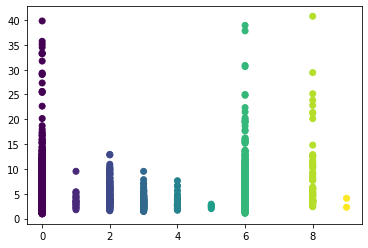

In [87]:
## distance from the center and corresponding class
dists = torch.norm(Zi-center.cpu().data.unsqueeze(0), dim=1)/np.sqrt(784)
plt.scatter(Ti, dists, c=Ti)

In [88]:
### mean, std dist of each class
for i in range(10):
    _ind = torch.nonzero(Ti==i)
    if len(_ind) < 1: continue
    _dat = dists[_ind]
    print(f"class: {i}, mean: {_dat.mean()}, std:{_dat.std()}")

class: 0, mean: 4.797850131988525, std:2.7120096683502197
class: 1, mean: 3.8066654205322266, std:1.7161931991577148
class: 2, mean: 5.126330375671387, std:2.364932060241699
class: 3, mean: 3.373481035232544, std:1.2473589181900024
class: 4, mean: 3.3251302242279053, std:1.4837702512741089
class: 5, mean: 2.465946674346924, std:0.33860406279563904
class: 6, mean: 4.635166168212891, std:3.059600353240967
class: 8, mean: 8.750611305236816, std:7.507153511047363
class: 9, mean: 3.1764893531799316, std:1.2779593467712402


In [39]:
asdfsadf

NameError: name 'asdfsadf' is not defined

### Select a node and train a new classifier: from transformed data

In [150]:
### make selecting index automatic
###### for all child index analyse how much incorrect training examples are present

### 1. train the cild with maximum incorrect ones.
### 2. train the network for at least 30,000 steps:
###     for a 5K dataset with 50 batch size, 100 steps in one epoch, so train for 300 epochs

MIN_POINTS = 10
batch_size = 50

max_incorrect = 0
max_inc_node = None
train_epoch = None
for ci in tree.get_all_child_index():
    node = tree.get_node(ci)
    num_data = len(node.train_indices)
    if num_data < MIN_POINTS: continue
        
    incorrect = num_data - node.num_correct
    if incorrect > max_incorrect:
        max_incorrect = incorrect
        max_inc_node = ci
        steps_in_epoch = max(num_data/batch_size, 1)
        train_epoch = int(30000/steps_in_epoch)
        
print(f"Max incorrect: {max_incorrect}, {max_inc_node}, train for: {train_epoch}")

Max incorrect: 932, [0, 3], train for: 233


In [151]:
###### for a given index of classifier make it 
# indx = [0, 0]
indx = max_inc_node
parent = tree.get_parent_node(indx)
node = tree.get_node(indx)

In [152]:
# node.train_indices, node.test_indices
node.pred, node.classes

(3, [0, 1, 2, 3, 4, 5, 6, 8])

In [153]:
alt_node = LocalClassifier(device)

In [154]:
# train_dataset.data = _train_data
# test_dataset.data = _test_data
# train_dataset.data = train_data
# test_dataset.data = test_data

In [155]:
### make classifier with only available classes
avl_cls = node.classes
num_cls = len(node.classes)
output_dim = 10
num_sets = num_cls*2
init_val = torch.abs(torch.randn(num_sets, output_dim)*0.01)
for ns in range(num_sets):
    init_val[ns, avl_cls[ns%num_cls]] = 2.

alt_node.create_network_0(784, [1], output_dim, num_sets)
alt_node.classifier.cls_weight.data = init_val.to(device)

alt_node.create_train_loader_1(train_dataset, node.train_indices, batch_size=50)
alt_node.create_test_loader_2(test_dataset, node.test_indices, batch_size=50)
alt_node.create_optimizer_3(lr=0.0003)

Train Dataset Num: 6418
Test Dataset Num: 1077


In [156]:
node.display_stats("")

[] : Train -> 0.8548 Test -> 0.8208, NUM: 6418, classes: 3:[0, 1, 2, 3, 4, 5, 6, 8]


In [157]:
alt_node.train_classifier_4(100)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0:0,  Loss:2.2072973251342773


  1%|          | 1/100 [00:01<01:44,  1.06s/it]

Train Acc:78.16%, Test Acc:82.17%

Epoch: 1:0,  Loss:2.1804540157318115


  2%|▏         | 2/100 [00:02<01:49,  1.12s/it]

Train Acc:85.40%, Test Acc:82.08%

Epoch: 2:0,  Loss:2.1238515377044678


  3%|▎         | 3/100 [00:03<01:46,  1.10s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 3:0,  Loss:2.1011385917663574


  4%|▍         | 4/100 [00:04<01:50,  1.15s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 4:0,  Loss:2.0497467517852783


  5%|▌         | 5/100 [00:05<01:45,  1.11s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 5:0,  Loss:1.9891499280929565


  6%|▌         | 6/100 [00:06<01:41,  1.08s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 6:0,  Loss:1.971926212310791


  7%|▋         | 7/100 [00:07<01:43,  1.11s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 7:0,  Loss:1.9344907999038696


  8%|▊         | 8/100 [00:08<01:42,  1.12s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 8:0,  Loss:1.8976527452468872


  9%|▉         | 9/100 [00:09<01:40,  1.11s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 9:0,  Loss:1.79519522190094


 10%|█         | 10/100 [00:11<01:38,  1.09s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 10:0,  Loss:1.978177547454834


 11%|█         | 11/100 [00:12<01:42,  1.15s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 11:0,  Loss:1.8416037559509277


 12%|█▏        | 12/100 [00:13<01:42,  1.17s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 12:0,  Loss:1.8594474792480469


 13%|█▎        | 13/100 [00:14<01:45,  1.21s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 13:0,  Loss:1.797974944114685


 14%|█▍        | 14/100 [00:16<01:43,  1.21s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 14:0,  Loss:1.7340868711471558


 15%|█▌        | 15/100 [00:17<01:41,  1.19s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 15:0,  Loss:1.6722246408462524


 16%|█▌        | 16/100 [00:18<01:37,  1.16s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 16:0,  Loss:1.6082801818847656


 17%|█▋        | 17/100 [00:19<01:32,  1.12s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 17:0,  Loss:1.5955730676651


 18%|█▊        | 18/100 [00:20<01:32,  1.13s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 18:0,  Loss:1.7337344884872437


 19%|█▉        | 19/100 [00:21<01:35,  1.17s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 19:0,  Loss:1.6257038116455078


 20%|██        | 20/100 [00:23<01:36,  1.21s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 20:0,  Loss:1.617297649383545


 21%|██        | 21/100 [00:24<01:33,  1.18s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 21:0,  Loss:1.5082011222839355


 22%|██▏       | 22/100 [00:25<01:36,  1.23s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 22:0,  Loss:1.7112672328948975


 23%|██▎       | 23/100 [00:26<01:32,  1.21s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 23:0,  Loss:1.7615470886230469


 24%|██▍       | 24/100 [00:27<01:30,  1.19s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 24:0,  Loss:1.5979491472244263


 25%|██▌       | 25/100 [00:28<01:28,  1.18s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 25:0,  Loss:1.5958564281463623


 26%|██▌       | 26/100 [00:30<01:29,  1.21s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 26:0,  Loss:1.6457549333572388


 27%|██▋       | 27/100 [00:31<01:26,  1.19s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 27:0,  Loss:1.6985371112823486


 28%|██▊       | 28/100 [00:32<01:28,  1.22s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 28:0,  Loss:1.5876357555389404


 29%|██▉       | 29/100 [00:33<01:25,  1.20s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 29:0,  Loss:1.532726764678955


 30%|███       | 30/100 [00:35<01:25,  1.22s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 30:0,  Loss:1.4759160280227661


 31%|███       | 31/100 [00:36<01:22,  1.19s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 31:0,  Loss:1.693036437034607


 32%|███▏      | 32/100 [00:37<01:23,  1.23s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 32:0,  Loss:1.636364459991455


 33%|███▎      | 33/100 [00:38<01:20,  1.20s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 33:0,  Loss:1.636491298675537


 34%|███▍      | 34/100 [00:39<01:17,  1.18s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 34:0,  Loss:1.4698474407196045


 35%|███▌      | 35/100 [00:40<01:15,  1.17s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 35:0,  Loss:1.5251288414001465


 36%|███▌      | 36/100 [00:42<01:16,  1.19s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 36:0,  Loss:1.7432829141616821


 37%|███▋      | 37/100 [00:43<01:13,  1.17s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 37:0,  Loss:1.5786186456680298


 38%|███▊      | 38/100 [00:44<01:09,  1.12s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 38:0,  Loss:1.5768290758132935


 39%|███▉      | 39/100 [00:45<01:05,  1.08s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 39:0,  Loss:1.4671484231948853


 40%|████      | 40/100 [00:46<01:05,  1.09s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 40:0,  Loss:1.465681791305542


 41%|████      | 41/100 [00:47<01:05,  1.11s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 41:0,  Loss:1.4664075374603271


 42%|████▏     | 42/100 [00:48<01:05,  1.13s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 42:0,  Loss:1.74089777469635


 43%|████▎     | 43/100 [00:49<01:05,  1.15s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 43:0,  Loss:1.6312183141708374


 44%|████▍     | 44/100 [00:51<01:05,  1.17s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 44:0,  Loss:1.629732370376587


 45%|████▌     | 45/100 [00:52<01:02,  1.13s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 45:0,  Loss:1.575219988822937


 46%|████▌     | 46/100 [00:53<01:01,  1.15s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 46:0,  Loss:1.6291648149490356


 47%|████▋     | 47/100 [00:54<01:00,  1.15s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 47:0,  Loss:1.4639569520950317


 48%|████▊     | 48/100 [00:55<00:56,  1.09s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 48:0,  Loss:1.7396860122680664


 49%|████▉     | 49/100 [00:56<00:53,  1.05s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 49:0,  Loss:1.6296080350875854


 50%|█████     | 50/100 [00:57<00:53,  1.07s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 50:0,  Loss:1.683949589729309


 51%|█████     | 51/100 [00:58<00:52,  1.08s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 51:0,  Loss:1.6847593784332275


 52%|█████▏    | 52/100 [00:59<00:52,  1.08s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 52:0,  Loss:1.6837226152420044


 53%|█████▎    | 53/100 [01:00<00:51,  1.10s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 53:0,  Loss:1.5735931396484375


 54%|█████▍    | 54/100 [01:01<00:49,  1.07s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 54:0,  Loss:1.5725270509719849


 55%|█████▌    | 55/100 [01:03<00:51,  1.15s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 55:0,  Loss:1.6844286918640137


 56%|█████▌    | 56/100 [01:04<00:50,  1.16s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 56:0,  Loss:1.6832658052444458


 57%|█████▋    | 57/100 [01:05<00:49,  1.15s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 57:0,  Loss:1.628657579421997


 58%|█████▊    | 58/100 [01:06<00:47,  1.13s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 58:0,  Loss:1.627667784690857


 59%|█████▉    | 59/100 [01:07<00:47,  1.16s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 59:0,  Loss:1.4621129035949707


 60%|██████    | 60/100 [01:09<00:46,  1.17s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 60:0,  Loss:1.6758320331573486


 61%|██████    | 61/100 [01:10<00:44,  1.13s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 61:0,  Loss:1.5730013847351074


 62%|██████▏   | 62/100 [01:11<00:42,  1.11s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 62:0,  Loss:1.6272857189178467


 63%|██████▎   | 63/100 [01:12<00:44,  1.20s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 63:0,  Loss:1.563101053237915


 64%|██████▍   | 64/100 [01:13<00:42,  1.18s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 64:0,  Loss:1.5161347389221191


 65%|██████▌   | 65/100 [01:14<00:39,  1.14s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 65:0,  Loss:1.6818959712982178


 66%|██████▌   | 66/100 [01:15<00:39,  1.17s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 66:0,  Loss:1.5716595649719238


 67%|██████▋   | 67/100 [01:17<00:38,  1.18s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 67:0,  Loss:1.5726457834243774


 68%|██████▊   | 68/100 [01:18<00:36,  1.15s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 68:0,  Loss:1.627184510231018


 69%|██████▉   | 69/100 [01:19<00:36,  1.16s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 69:0,  Loss:1.461625099182129


 70%|███████   | 70/100 [01:20<00:35,  1.20s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 70:0,  Loss:1.6152710914611816


 71%|███████   | 71/100 [01:21<00:33,  1.15s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 71:0,  Loss:1.6281547546386719


 72%|███████▏  | 72/100 [01:22<00:31,  1.14s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 72:0,  Loss:1.7257905006408691


 73%|███████▎  | 73/100 [01:24<00:30,  1.15s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 73:0,  Loss:1.5171875953674316


 74%|███████▍  | 74/100 [01:25<00:29,  1.13s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 74:0,  Loss:1.460201621055603


 75%|███████▌  | 75/100 [01:26<00:27,  1.09s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 75:0,  Loss:1.7392497062683105


 76%|███████▌  | 76/100 [01:27<00:25,  1.08s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 76:0,  Loss:1.6826952695846558


 77%|███████▋  | 77/100 [01:28<00:25,  1.11s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 77:0,  Loss:1.6835989952087402


 78%|███████▊  | 78/100 [01:29<00:26,  1.18s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 78:0,  Loss:1.557637095451355


 79%|███████▉  | 79/100 [01:30<00:24,  1.15s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 79:0,  Loss:1.7389330863952637


 80%|████████  | 80/100 [01:31<00:23,  1.15s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 80:0,  Loss:1.571500539779663


 81%|████████  | 81/100 [01:33<00:21,  1.14s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 81:0,  Loss:1.7249678373336792


 82%|████████▏ | 82/100 [01:34<00:20,  1.11s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 82:0,  Loss:1.7382850646972656


 83%|████████▎ | 83/100 [01:35<00:18,  1.12s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 83:0,  Loss:1.6084660291671753


 84%|████████▍ | 84/100 [01:36<00:17,  1.11s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 84:0,  Loss:1.5713273286819458


 85%|████████▌ | 85/100 [01:37<00:17,  1.15s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 85:0,  Loss:1.5166637897491455


 86%|████████▌ | 86/100 [01:38<00:16,  1.15s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 86:0,  Loss:1.459993600845337


 87%|████████▋ | 87/100 [01:39<00:14,  1.12s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 87:0,  Loss:1.6254762411117554


 88%|████████▊ | 88/100 [01:41<00:14,  1.17s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 88:0,  Loss:1.4599605798721313


 89%|████████▉ | 89/100 [01:42<00:13,  1.18s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 89:0,  Loss:1.5167685747146606


 90%|█████████ | 90/100 [01:43<00:12,  1.20s/it]

Train Acc:85.48%, Test Acc:82.08%

Epoch: 90:0,  Loss:1.4600739479064941


 91%|█████████ | 91/100 [01:44<00:10,  1.19s/it]

Train Acc:85.59%, Test Acc:81.99%

Epoch: 91:0,  Loss:1.6277401447296143


 92%|█████████▏| 92/100 [01:45<00:09,  1.18s/it]

Train Acc:85.65%, Test Acc:81.99%

Epoch: 92:0,  Loss:1.5156452655792236


 93%|█████████▎| 93/100 [01:47<00:08,  1.17s/it]

Train Acc:85.84%, Test Acc:82.08%

Epoch: 93:0,  Loss:1.6275800466537476


 94%|█████████▍| 94/100 [01:48<00:06,  1.16s/it]

Train Acc:85.96%, Test Acc:82.36%

Epoch: 94:0,  Loss:1.5155667066574097


 95%|█████████▌| 95/100 [01:49<00:05,  1.17s/it]

Train Acc:86.02%, Test Acc:82.36%

Epoch: 95:0,  Loss:1.7388880252838135


 96%|█████████▌| 96/100 [01:50<00:04,  1.25s/it]

Train Acc:85.99%, Test Acc:82.17%

Epoch: 96:0,  Loss:1.5710333585739136


 97%|█████████▋| 97/100 [01:51<00:03,  1.18s/it]

Train Acc:86.09%, Test Acc:82.27%

Epoch: 97:0,  Loss:1.6833056211471558


 98%|█████████▊| 98/100 [01:52<00:02,  1.17s/it]

Train Acc:86.12%, Test Acc:82.27%

Epoch: 98:0,  Loss:1.5772260427474976


 99%|█████████▉| 99/100 [01:54<00:01,  1.17s/it]

Train Acc:86.16%, Test Acc:82.08%

Epoch: 99:0,  Loss:1.5165534019470215


100%|██████████| 100/100 [01:55<00:00,  1.15s/it]

Train Acc:86.18%, Test Acc:82.27%

	-> MAX Train Acc 86.17949516983484 ; Test Acc 82.35840297121634


In [146]:
alt_node.freeze_and_compute_stats_5(MIN_POINTS)

Keeping only N=13/18 classifiers.
Hard inference on the data !
idx: 0	out: 1 	 acc: 82.759 	classes:[1, 3, 6, 8]
idx: 1	out: 3 	 acc: 86.818 	classes:[0, 1, 2, 3, 4, 6, 8]
idx: 2	out: 4 	 acc: 82.253 	classes:[0, 2, 3, 4, 6, 8]
idx: 3	out: 5 	 acc: 98.408 	classes:[3, 4, 5, 7, 9]
idx: 4	out: 6 	 acc: 86.709 	classes:[0, 1, 2, 3, 4, 6, 8]
idx: 5	out: 8 	 acc: 97.849 	classes:[0, 5, 6, 8]
idx: 6	out: 9 	 acc: 96.693 	classes:[5, 6, 7, 8, 9]
idx: 7	out: 0 	 acc: 80.000 	classes:[0, 1, 2, 3, 4, 6, 8]
idx: 8	out: 1 	 acc: 99.384 	classes:[1, 2, 3, 8]
idx: 9	out: 2 	 acc: 82.575 	classes:[0, 2, 3, 4, 6]
idx: 10	out: 3 	 acc: 95.400 	classes:[0, 1, 2, 3, 4, 6]
idx: 11	out: 7 	 acc: 98.300 	classes:[5, 7, 9]
idx: 12	out: 8 	 acc: 92.560 	classes:[0, 2, 3, 5, 6, 7, 8, 9]
Accuracy: 0.911376292760541


(tensor([[  4.7960,  -5.5771,  -2.7656,  ...,   1.9072,  -3.5556,  -7.1005],
         [  1.3617,   4.4848,  -4.9356,  ...,  -2.4108,   3.9407,   6.0892],
         [ -0.2870,   0.8663,  -1.0293,  ...,  -2.4732,   1.0299,   1.0621],
         ...,
         [ 30.9270,  -3.8843, -10.9497,  ..., -20.4506,  -5.4742, -20.3903],
         [ -2.1501,  -2.5783,  -3.9929,  ...,   0.5605,   1.0461,   0.4362],
         [  5.4957,   3.6400,   2.6034,  ...,   2.8570,   4.7977,  -6.9150]]),
 tensor([9, 0, 0,  ..., 8, 4, 3]),
 tensor([[-0.5905, -2.1529, -0.9238,  ..., -1.4238, -0.9629,  0.3813],
         [ 4.5488,  2.8270, -6.9544,  ..., -1.4724, -4.5993,  2.3274],
         [ 4.2065, -6.0886,  4.5688,  ..., -9.1891, -4.7958, -4.2356],
         ...,
         [ 8.5736, -2.1897,  7.4272,  ..., -5.6298, -7.0694, -7.9919],
         [ 5.6363,  3.5565,  2.4963,  ...,  1.7766,  1.4932, -5.7108],
         [-1.4226,  1.6827, -4.4564,  ...,  2.1967, -0.7798,  1.6088]]),
 tensor([9, 2, 1,  ..., 1, 3, 4]))

In [147]:
alt_node.display_stats("")

[, 0] : Train -> 0.8276 Test -> 0.6000, NUM: 29, classes: 1:[1, 3, 6, 8]
[, 1] : Train -> 0.8682 Test -> 0.6667, NUM: 220, classes: 3:[0, 1, 2, 3, 4, 6, 8]
[, 2] : Train -> 0.8225 Test -> 0.7833, NUM: 648, classes: 4:[0, 2, 3, 4, 6, 8]
[, 3] : Train -> 0.9841 Test -> 0.9121, NUM: 628, classes: 5:[3, 4, 5, 7, 9]
[, 4] : Train -> 0.8671 Test -> 0.6310, NUM: 474, classes: 6:[0, 1, 2, 3, 4, 6, 8]
[, 5] : Train -> 0.9785 Test -> 0.9697, NUM: 279, classes: 8:[0, 5, 6, 8]
[, 6] : Train -> 0.9669 Test -> 0.9684, NUM: 635, classes: 9:[5, 6, 7, 8, 9]
[, 7] : Train -> 0.8000 Test -> 0.7603, NUM: 690, classes: 0:[0, 1, 2, 3, 4, 6, 8]
[, 8] : Train -> 0.9938 Test -> 0.9612, NUM: 649, classes: 1:[1, 2, 3, 8]
[, 9] : Train -> 0.8257 Test -> 0.7438, NUM: 637, classes: 2:[0, 2, 3, 4, 6]
[, 10] : Train -> 0.9540 Test -> 0.9206, NUM: 413, classes: 3:[0, 1, 2, 3, 4, 6]
[, 11] : Train -> 0.9830 Test -> 0.8812, NUM: 647, classes: 7:[5, 7, 9]
[, 12] : Train -> 0.9256 Test -> 0.8750, NUM: 336, classes: 8:[0, 

In [148]:
### replace the leaf node with Local Classifier Node
parent.children[indx[-1]] = alt_node

In [149]:
#### After modification status
tree.display_stats()

[0, 0, 0, 0] : Train -> 0.8276 Test -> 0.6000, NUM: 29, classes: 1:[1, 3, 6, 8]
[0, 0, 0, 1] : Train -> 0.8682 Test -> 0.6667, NUM: 220, classes: 3:[0, 1, 2, 3, 4, 6, 8]
[0, 0, 0, 2] : Train -> 0.8225 Test -> 0.7833, NUM: 648, classes: 4:[0, 2, 3, 4, 6, 8]
[0, 0, 0, 3] : Train -> 0.9841 Test -> 0.9121, NUM: 628, classes: 5:[3, 4, 5, 7, 9]
[0, 0, 0, 4] : Train -> 0.8671 Test -> 0.6310, NUM: 474, classes: 6:[0, 1, 2, 3, 4, 6, 8]
[0, 0, 0, 5] : Train -> 0.9785 Test -> 0.9697, NUM: 279, classes: 8:[0, 5, 6, 8]
[0, 0, 0, 6] : Train -> 0.9669 Test -> 0.9684, NUM: 635, classes: 9:[5, 6, 7, 8, 9]
[0, 0, 0, 7] : Train -> 0.8000 Test -> 0.7603, NUM: 690, classes: 0:[0, 1, 2, 3, 4, 6, 8]
[0, 0, 0, 8] : Train -> 0.9938 Test -> 0.9612, NUM: 649, classes: 1:[1, 2, 3, 8]
[0, 0, 0, 9] : Train -> 0.8257 Test -> 0.7438, NUM: 637, classes: 2:[0, 2, 3, 4, 6]
[0, 0, 0, 10] : Train -> 0.9540 Test -> 0.9206, NUM: 413, classes: 3:[0, 1, 2, 3, 4, 6]
[0, 0, 0, 11] : Train -> 0.9830 Test -> 0.8812, NUM: 647, cla

In [ ]:
[0, 0, 0, 0] : pred -> 0.9799, NUM: 546, classes: [0, 2, 4, 6]
[0, 0, 0, 1] : pred -> 0.9983, NUM: 606, classes: [1, 2]
[0, 0, 0, 2] : pred -> 0.9831, NUM: 592, classes: [0, 2, 4, 6]
[0, 0, 0, 3] : pred -> 0.9788, NUM: 565, classes: [0, 1, 2, 3, 4, 6, 8]
[0, 0, 0, 4] : pred -> 0.9744, NUM: 586, classes: [1, 2, 3, 4, 6]
[0, 0, 0, 5] : pred -> 1.0000, NUM: 589, classes: [5]
[0, 0, 0, 6] : pred -> 0.9898, NUM: 588, classes: [0, 1, 2, 4, 6]
[0, 0, 0, 7] : pred -> 0.9877, NUM: 568, classes: [5, 7, 9]
[0, 0, 0, 8] : pred -> 0.9966, NUM: 592, classes: [0, 8]
[0, 0, 0, 9] : pred -> 0.9947, NUM: 565, classes: [5, 7, 9]
[0, 0, 1, 0] : pred -> 0.9571, NUM: 163, classes: [0, 6]
[0, 0, 1, 1] : pred -> 1.0000, NUM: 149, classes: [1]
[0, 0, 1, 2] : pred -> 0.9940, NUM: 168, classes: [2, 4]
[0, 0, 1, 3] : pred -> 0.9939, NUM: 164, classes: [3, 6]
[0, 0, 1, 4] : pred -> 0.9827, NUM: 173, classes: [2, 4, 6]
[0, 0, 1, 5] : pred -> 1.0000, NUM: 167, classes: [5]
[0, 0, 1, 6] : pred -> 1.0000, NUM: 143, classes: [6]
[0, 0, 1, 7] : pred -> 0.9934, NUM: 151, classes: [7, 8]
[0, 0, 1, 8] : pred -> 0.9864, NUM: 147, classes: [0, 6, 8]
[0, 0, 1, 9] : pred -> 0.9831, NUM: 177, classes: [7, 9]
[0, 1] : pred -> 0.9888, NUM: 5898, classes: [0, 1, 2, 3, 4, 6, 8, 9]
[0, 2, 0, 0] : pred -> 0.9571, NUM: 466, classes: [0, 1, 2, 4, 6, 8]
[0, 2, 0, 1] : pred -> 1.0000, NUM: 476, classes: [1]
[0, 2, 0, 2] : pred -> 0.9876, NUM: 483, classes: [2, 3, 4, 6]
[0, 2, 0, 3] : pred -> 0.9912, NUM: 457, classes: [0, 3, 4, 6]
[0, 2, 0, 4] : pred -> 0.9790, NUM: 477, classes: [2, 3, 4, 6]
[0, 2, 0, 5] : pred -> 1.0000, NUM: 451, classes: [5]
[0, 2, 0, 6] : pred -> 0.9956, NUM: 456, classes: [2, 4, 6]
[0, 2, 0, 7] : pred -> 0.9886, NUM: 440, classes: [5, 7, 8, 9]
[0, 2, 0, 8] : pred -> 0.9883, NUM: 426, classes: [0, 6, 8]
[0, 2, 0, 9] : pred -> 0.9918, NUM: 490, classes: [5, 7, 9]
[0, 2, 1] : pred -> 0.8632, NUM: 541, classes: [0, 1, 3, 4, 5, 6]
[0, 2, 2] : pred -> 0.8750, NUM: 8, classes: [0, 4]
[0, 2, 3] : pred -> 0.8986, NUM: 138, classes: [0, 1, 3, 4, 6, 8]
[0, 2, 4] : pred -> 0.8000, NUM: 5, classes: [0, 4]
[0, 3, 0] : pred -> 0.9524, NUM: 210, classes: [0, 1, 2, 6, 8]
[0, 3, 1] : pred -> 1.0000, NUM: 7, classes: [2]
[0, 3, 2] : pred -> 0.9417, NUM: 5988, classes: [0, 1, 2, 3, 4, 5, 6, 8]
[0, 3, 3, 0] : pred -> 0.9672, NUM: 61, classes: [0, 6]
[0, 3, 3, 1] : pred -> 1.0000, NUM: 56, classes: [1]
[0, 3, 3, 2] : pred -> 1.0000, NUM: 43, classes: [2]
[0, 3, 3, 3] : pred -> 0.9583, NUM: 48, classes: [3, 4, 6]
[0, 3, 3, 4] : pred -> 0.9811, NUM: 53, classes: [2, 4]
[0, 3, 3, 5] : pred -> 1.0000, NUM: 44, classes: [5]
[0, 3, 3, 6] : pred -> 0.9796, NUM: 49, classes: [0, 6]
[0, 3, 3, 7] : pred -> 1.0000, NUM: 53, classes: [7]
[0, 3, 3, 8] : pred -> 1.0000, NUM: 48, classes: [8]
[0, 3, 3, 9] : pred -> 1.0000, NUM: 53, classes: [9]
[0, 4, 0, 0] : pred -> 1.0000, NUM: 103, classes: [0]
[0, 4, 0, 1] : pred -> 1.0000, NUM: 117, classes: [1]
[0, 4, 0, 2] : pred -> 0.9910, NUM: 111, classes: [2, 6]
[0, 4, 0, 3] : pred -> 1.0000, NUM: 112, classes: [3]
[0, 4, 0, 4] : pred -> 1.0000, NUM: 117, classes: [4]
[0, 4, 0, 5] : pred -> 1.0000, NUM: 110, classes: [5]
[0, 4, 0, 6] : pred -> 1.0000, NUM: 119, classes: [6]
[0, 4, 0, 7] : pred -> 0.9831, NUM: 118, classes: [5, 7, 9]
[0, 4, 0, 8] : pred -> 1.0000, NUM: 103, classes: [8]
[0, 4, 0, 9] : pred -> 1.0000, NUM: 124, classes: [9]
[0, 4, 1, 0] : pred -> 0.9752, NUM: 483, classes: [0, 2, 6]
[0, 4, 1, 1] : pred -> 0.9981, NUM: 520, classes: [1, 3]
[0, 4, 1, 2] : pred -> 0.9693, NUM: 521, classes: [0, 2, 4, 6, 8]
[0, 4, 1, 3] : pred -> 0.9838, NUM: 493, classes: [1, 2, 3, 4, 6]
[0, 4, 1, 4] : pred -> 0.9745, NUM: 510, classes: [0, 2, 3, 4, 6]
[0, 4, 1, 5] : pred -> 1.0000, NUM: 497, classes: [5]
[0, 4, 1, 6] : pred -> 0.9917, NUM: 482, classes: [0, 2, 3, 4, 6]
[0, 4, 1, 7] : pred -> 0.9874, NUM: 476, classes: [5, 7, 9]
[0, 4, 1, 8] : pred -> 0.9939, NUM: 493, classes: [0, 6, 8]
[0, 4, 1, 9] : pred -> 0.9941, NUM: 511, classes: [7, 9]
[0, 5] : pred -> 0.9624, NUM: 5902, classes: [0, 1, 2, 3, 4, 5, 7, 8, 9]
[0, 6, 0] : pred -> 0.9314, NUM: 452, classes: [0, 1, 2, 3, 4, 8]
[0, 6, 1, 0] : pred -> 0.9726, NUM: 401, classes: [0, 2, 6]
[0, 6, 1, 1] : pred -> 1.0000, NUM: 403, classes: [1]
[0, 6, 1, 2] : pred -> 0.9851, NUM: 404, classes: [1, 2, 3, 4, 6]
[0, 6, 1, 3] : pred -> 0.9814, NUM: 376, classes: [1, 2, 3, 4, 6]
[0, 6, 1, 4] : pred -> 0.9754, NUM: 407, classes: [2, 3, 4, 6]
[0, 6, 1, 5] : pred -> 1.0000, NUM: 396, classes: [5]
[0, 6, 1, 6] : pred -> 0.9897, NUM: 388, classes: [2, 4, 6, 8]
[0, 6, 1, 7] : pred -> 0.9923, NUM: 391, classes: [5, 7, 8, 9]
[0, 6, 1, 8] : pred -> 0.9972, NUM: 362, classes: [7, 8]
[0, 6, 1, 9] : pred -> 0.9910, NUM: 444, classes: [5, 7, 9]
[0, 6, 2] : pred -> 1.0000, NUM: 11, classes: [8]
[0, 7, 0] : pred -> 1.0000, NUM: 100, classes: [5]
[0, 7, 1] : pred -> 0.9763, NUM: 5877, classes: [5, 7, 8, 9]
[0, 7, 2] : pred -> 0.7500, NUM: 8, classes: [6, 8]
[0, 7, 3] : pred -> 0.9838, NUM: 308, classes: [5, 9]
[0, 8] : pred -> 0.9482, NUM: 6123, classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 9] : pred -> 0.9605, NUM: 5803, classes: [0, 1, 4, 5, 6, 7, 8, 9]
Final Accuracy is : 0.97130